In [1]:
from sigpyproc.Readers import FilReader
from tqdm import tqdm
import numpy as np
from lmfit import minimize, Parameters, fit_report, Model
import pickle

from scipy.signal import savgol_filter, resample, correlate
from scipy.fft import fft2, fftshift

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

from scinttools import *
from burstfittools import *

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['cmr10']
rcParams['font.size'] = 15
rcParams['axes.formatter.use_mathtext'] = True
rcParams['axes.unicode_minus'] = False
rcParams['mathtext.fontset'] = 'cm'
rcParams['text.usetex'] = False

/home/ubuntu/anaconda3/envs/casa38/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: v0.0.0-44-gc4edec3-dirty is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ubuntu/anaconda3/envs/casa38/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: v1.4.0-7-g6469766 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ubuntu/anaconda3/envs/casa38/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.2.1-6-g1a8a603-dirty is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ubuntu/anaconda3/envs/casa38/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.2.1-6-g1a8a603 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ubuntu/anaconda3/envs/casa38/lib/python3.8/site-packages/pkg_resour

In [2]:
basepath = '/media/ubuntu/ssd/jfaber/CHIME_DSA_Codetections/polcal_fils'
with open(os.path.join(basepath, 'casey_240229aaad_fullstokes_interp.pkl'), 'rb') as file:
    data = pickle.load(file)  # The file is open only within this block

In [3]:
tres = data['delta_t (ms)']
fres = data['delta_f (MHz)']

intensity = data['I']
outerbound = int(intensity.shape[1] * 5/12)

intensity = intensity[:, outerbound:-outerbound]

timeseries = np.nansum(intensity, axis = 0)
timesamples = np.linspace(0, intensity.shape[1]*tres, intensity.shape[1])
timerange = np.abs(timesamples[-1] - timesamples[0])
timesamples_mod = np.linspace(-timerange/2, timerange/2, len(timesamples))
timeshift = -1 * int(timesamples_mod[np.argmax(timeseries)] / tres)

intensity = np.roll(intensity, timeshift, axis = 1)
spectrum = np.nansum(intensity, axis = 1)
timeseries = np.nansum(intensity, axis = 0)

from matplotlib.colors import LogNorm

fig, axes = plt.subplots(
        nrows=2, ncols=1, sharex=False, sharey=False, 
        gridspec_kw={'height_ratios':[1.25,2]},
        figsize = (9, 10))

# Increase border thickness
current_axes = plt.gca()
axes[0].spines['top'].set_linewidth(3)
axes[0].spines['bottom'].set_linewidth(3)
axes[0].spines['left'].set_linewidth(3)
axes[0].spines['right'].set_linewidth(3)

axes[1].spines['top'].set_linewidth(3)
axes[1].spines['bottom'].set_linewidth(3)
axes[1].spines['left'].set_linewidth(3)
axes[1].spines['right'].set_linewidth(3)

axes[0].tick_params(which='both', width=2,)
axes[0].tick_params(which='major', length=7)
axes[0].tick_params(which='minor', length=5)
axes[0].tick_params(which='minor', axis = 'y', length=5)

axes[0].step(timesamples_mod, timeseries, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[0].set_yticks([0, 1])
axes[0].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0].set_yticks([])
axes[0].set_xlim(timesamples_mod[0], timesamples_mod[-1])
axes[0].legend(loc = 'upper right', fontsize = 30, frameon = False)

mean = np.nanmean(intensity)
std = np.nanstd(intensity)
axes[1].imshow(intensity, vmin = mean - 2*std, vmax = mean + 2*std, extent = [timesamples_mod[0], timesamples_mod[-1], 1300, 1500], cmap = 'plasma', aspect = 'auto') 
axes[1].set_ylabel('Frequency [MHz]')
axes[1].set_xlabel('Time [ms]')
axes[1].tick_params(which='both', width=2)
axes[1].tick_params(which='major', length=7)
axes[1].tick_params(which='minor', length=5)
axes[1].tick_params(which='minor', axis = 'y', length=5)

#axes[1].set_xlim(40, 150)
plt.subplots_adjust(hspace=0)


KeyboardInterrupt: 

In [4]:
f_factor = 190*4
t_factor = 2
intensity_ds = downsample_data(intensity, f_factor = f_factor, t_factor = t_factor)

Power Shape (frequency axis): 6144
Power Shape (time axis): 1562
Nearest Multiple To Downsampling Factor (frequency): 6080
Nearest Multiple To Downsampling Factor (time): 1562
Downsampled Data Shape: (8, 781)


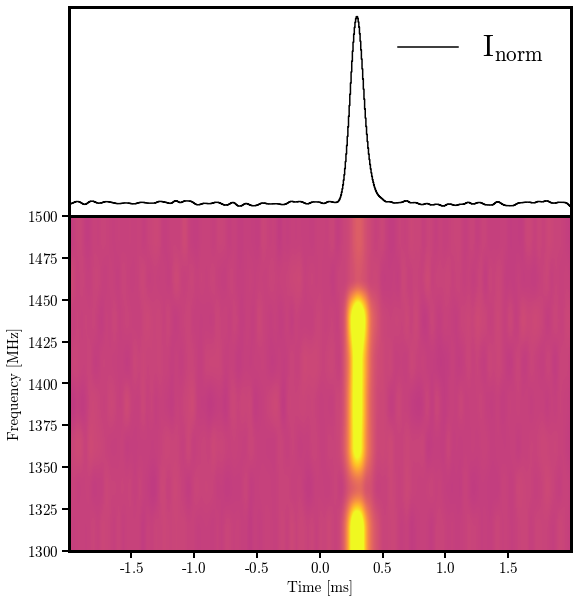

In [6]:
fres_ds = fres * f_factor
tres_ds = tres * t_factor

intensity_ds_norm = intensity_ds / np.max(intensity_ds)
timeseries_ds = np.nansum(intensity_ds, axis = 0)
timeseries_ds_norm = timeseries_ds / np.max(timeseries_ds)
timesamples_ds = np.linspace(0, intensity_ds.shape[1]*tres_ds, intensity_ds.shape[1])
timerange_ds = np.abs(timesamples_ds[-1] - timesamples_ds[0])
timesamples_mod_ds = np.linspace(-timerange_ds/2, timerange_ds/2, len(timesamples_ds))

spectrum = np.nansum(intensity_ds, axis = 1)
timeseries = np.nansum(intensity_ds, axis = 0)

from matplotlib.colors import LogNorm

fig, axes = plt.subplots(
        nrows=2, ncols=1, sharex=False, sharey=False, 
        gridspec_kw={'height_ratios':[1.25,2]},
        figsize = (9, 10))

# Increase border thickness
current_axes = plt.gca()
axes[0].spines['top'].set_linewidth(3)
axes[0].spines['bottom'].set_linewidth(3)
axes[0].spines['left'].set_linewidth(3)
axes[0].spines['right'].set_linewidth(3)

axes[1].spines['top'].set_linewidth(3)
axes[1].spines['bottom'].set_linewidth(3)
axes[1].spines['left'].set_linewidth(3)
axes[1].spines['right'].set_linewidth(3)

axes[0].tick_params(which='both', width=2,)
axes[0].tick_params(which='major', length=7)
axes[0].tick_params(which='minor', length=5)
axes[0].tick_params(which='minor', axis = 'y', length=5)

axes[0].step(timesamples_mod_ds, timeseries_ds_norm, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[0].set_yticks([0, 1])
axes[0].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0].set_yticks([])
axes[0].set_xlim(timesamples_mod_ds[0], timesamples_mod_ds[-1])
axes[0].legend(loc = 'upper right', fontsize = 30, frameon = False)

mean_ds = np.nanmean(intensity_ds_norm)
std_ds = np.nanstd(intensity_ds_norm)
axes[1].imshow(intensity_ds_norm, vmin = mean_ds - 6*std_ds, vmax = mean_ds + 6*std_ds, extent = [timesamples_mod_ds[0], timesamples_mod_ds[-1], 1300, 1500], cmap = 'plasma', aspect = 'auto') 
axes[1].set_ylabel('Frequency [MHz]')
axes[1].set_xlabel('Time [ms]')
axes[1].tick_params(which='both', width=2)
axes[1].tick_params(which='major', length=7)
axes[1].tick_params(which='minor', length=5)
axes[1].tick_params(which='minor', axis = 'y', length=5)

#axes[1].set_xlim(40, 150)
plt.subplots_adjust(hspace=0)


In [7]:
n_channels = intensity_ds.shape[0]
n_samples = intensity_ds.shape[1]

# Create time array (ms)
time = np.linspace(0, n_samples*tres_ds, n_samples)

# Create frequency array with 128 channels
f_b = 1.3  # GHz
f_t = 1.5    # GHz
freq = np.linspace(f_b, f_t, n_channels)

# Set parameters for Model 3
#c0 = 1.0  # Reference flux at reference frequency
#spectral_index = 2.5
#t0 = 1.0  # ms
dm_init = 0.0
#DM_err = 0.0
#zeta = 0.08
#tau_1GHz = 0.6
#alpha = 4.0

# Parameters array for model 3
#params = [c0, spectral_index, t0, DM_err, zeta, tau_1GHz, alpha]

# Initialize the model and data
#data = np.zeros((N_channels, N_time_samples))
model_instance = FRBModel(intensity_ds_norm, time, freq, dm_init)

# Add Gaussian noise to the simulated data
#np.random.seed(42)  # For reproducibility
#noise_level = 0.05 * np.max(simulated_data)  # Adjust noise level as needed
#noise = noise_level * np.random.randn(*simulated_data.shape)
#simulated_data_noisy = simulated_data + noise
#simulated_data_timeseries = simulated_data_noisy.sum(0) / np.max(simulated_data_noisy.sum(0))

2.296700717948718


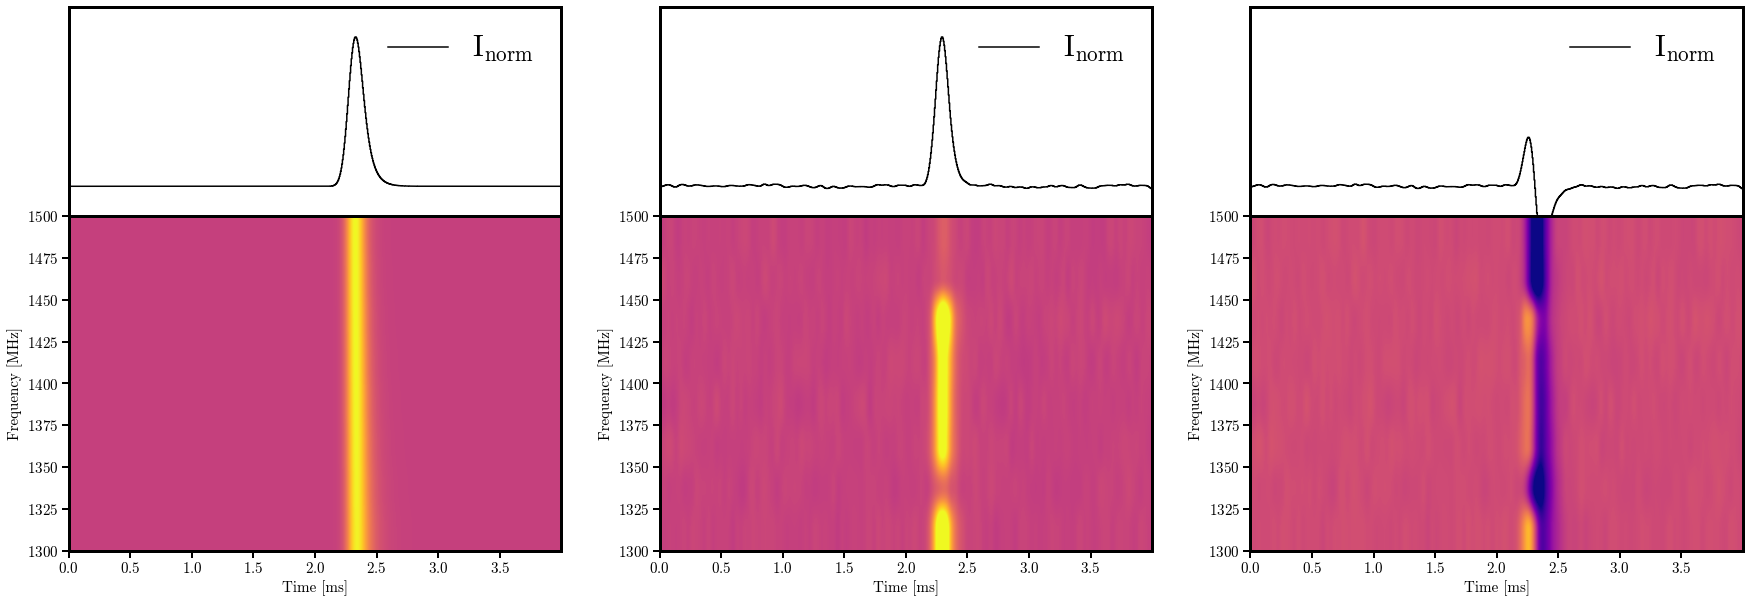

In [8]:
# Generate simulated data
c0_init = np.max(np.sum(intensity_ds_norm, axis=1)) / intensity_ds_norm.shape[1]
t0_init = timesamples_ds[np.argmax(np.sum(intensity_ds_norm, axis=0))]
print(t0_init)
gamma_init = -1.0
DM_err_init = 0.0
zeta_init = 0.05
tau_init = 0.2
alpha_init = 4.0

model_type = 'model3'

sim_params = None
    
if model_type == 'model0':
    sim_params = [c0_init, t0_init, gamma_init, DM_err_init, 0., 0., 0.]

elif model_type == 'model1':
    sim_params = [c0_init, t0_init, gamma_init, DM_err_init, zeta_init, 0., 0.]

elif model_type == 'model2':
    sim_params = [c0_init, t0_init, gamma_init, DM_err_init, tau_init, alpha_init, 0.]

elif model_type == 'model3':
    sim_params = [c0_init, t0_init, gamma_init, DM_err_init, zeta_init, tau_init, alpha_init]

simulated_data = model_instance.model(sim_params, model_type=model_type)
simulated_data_norm = simulated_data / np.max(simulated_data)

sim_fres = fres_ds
sim_tres = tres_ds
sim_timeseries = np.nansum(simulated_data, axis = 0)
sim_timeseries_norm = sim_timeseries / np.max(sim_timeseries)
sim_timesamples = np.linspace(0, simulated_data.shape[1]*sim_tres, simulated_data.shape[1])
sim_timerange = np.abs(sim_timesamples[-1] - sim_timesamples[0])
sim_timesamples_mod = np.linspace(-sim_timerange/2, sim_timerange/2, len(sim_timesamples))
sim_spectrum = np.nansum(simulated_data, axis = 1)
sim_spectrum_norm = sim_spectrum / np.max(sim_spectrum)

# Compute residuals
intensity_rsdl = intensity_ds_norm - simulated_data_norm
timeseries_rsdl = timeseries_ds_norm - sim_timeseries_norm

from matplotlib.colors import LogNorm

fig, axes = plt.subplots(
        nrows=2, ncols=3, sharex=False, sharey=False, 
        gridspec_kw={'height_ratios':[1.25,2]},
        figsize = (30, 10))

# Increase border thickness
current_axes = plt.gca()
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
for ax_row in axes:
    for ax in ax_row:
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis = 'y', length=5)

axes[0, 0].step(sim_timesamples, sim_timeseries_norm, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[0, 0].set_yticks([0, 1])
axes[0, 0].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 0].set_yticks([])
axes[0, 0].set_ylim(-0.2, 1.2)
axes[0, 0].set_xlim(sim_timesamples[0], sim_timesamples[-1])
axes[0, 0].legend(loc = 'upper right', fontsize = 30, frameon = False)

sim_mean = np.nanmean(simulated_data_norm)
sim_std = np.nanstd(simulated_data_norm)
axes[1, 0].imshow(simulated_data_norm, vmin = sim_mean - 6*sim_std, vmax = sim_mean + 6*sim_std, extent = [sim_timesamples[0], sim_timesamples[-1], 1300, 1500], cmap = 'plasma', aspect = 'auto') 
#cbar = plt.colorbar(im1, ax=axes[1, 0])
#cbar.set_label('Intensity', rotation=270, labelpad=15)
axes[1, 0].set_ylabel('Frequency [MHz]')
axes[1, 0].set_xlabel('Time [ms]')

axes[0, 1].step(timesamples_ds, timeseries_ds_norm, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[0, 1].set_yticks([0, 1])
axes[0, 1].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 1].set_yticks([])
axes[0, 1].set_ylim(-0.2, 1.2)
axes[0, 1].set_xlim(timesamples_ds[0], timesamples_ds[-1])
axes[0, 1].legend(loc = 'upper right', fontsize = 30, frameon = False)

mean_ds = np.nanmean(intensity_ds_norm)
std_ds = np.nanstd(intensity_ds_norm)
axes[1, 1].imshow(intensity_ds_norm, vmin = mean_ds - 6*std_ds, vmax = mean_ds + 6*std_ds, extent = [sim_timesamples[0], sim_timesamples[-1], 1300, 1500], cmap = 'plasma', aspect = 'auto') 
axes[1, 1].set_ylabel('Frequency [MHz]')
axes[1, 1].set_xlabel('Time [ms]')

axes[0, 2].step(sim_timesamples, timeseries_rsdl, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[0, 2].set_yticks([0, 1])
axes[0, 2].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 2].set_yticks([])
axes[0, 2].set_ylim(-0.2, 1.2)
axes[0, 2].set_xlim(sim_timesamples[0], sim_timesamples[-1])
axes[0, 2].legend(loc = 'upper right', fontsize = 30, frameon = False)

sim_mean = np.nanmean(intensity_rsdl)
sim_std = np.nanstd(intensity_rsdl)
axes[1, 2].imshow(intensity_rsdl, vmin = sim_mean - 6*sim_std, vmax = sim_mean + 6*sim_std, extent = [sim_timesamples[0], sim_timesamples[-1], 1300, 1500], cmap = 'plasma', aspect = 'auto') 
axes[1, 2].set_ylabel('Frequency [MHz]')
axes[1, 2].set_xlabel('Time [ms]')

#axes[1].set_xlim(40, 150)
plt.subplots_adjust(hspace=0)


In [12]:
from burstfittools import fit_models

In [13]:
# Fit the models
prior_bounds = {
        'c0': (1e-3, 100),  # Adjusted as per prior
        't0': (time[0], time[-1]),
        'spectral_index': (-3, 1),
        'DM_err': (-0.001, 0.001),
        'zeta': (0, 0.4),
        'tau_1GHz': (0, 0.4),
        'alpha': (3.5, 4.5)
    }


results, best_model = fit_models(model_instance, sim_params, prior_bounds, fit_m0=False, fit_m1=False, fit_m2=False, fit_m3=True)
print(f"The best-fitting model is: {best_model}")

SyntaxError: invalid syntax (2425546905.py, line 9)

In [12]:
print(prior_bounds['c0'][0])

0.001


Mean acceptance fraction (should be 0.2-0.5): 0.23402


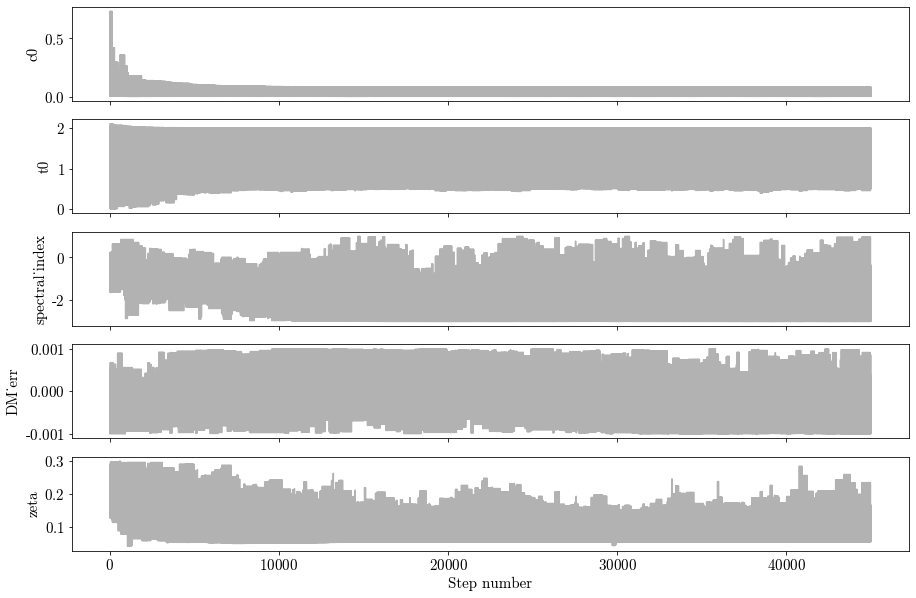

In [9]:
# Extract the sampler
best_sampler = results[best_model]['sampler']

print("Mean acceptance fraction (should be 0.2-0.5):", np.mean(best_sampler.acceptance_fraction))

# Check for NaN or Inf in Sampler
log_probs = best_sampler.get_log_prob()
if np.any(~np.isfinite(log_probs)):
    print("Found NaN or Inf in log-probabilities.")

#samples = best_sampler.get_chain(flat=True)
# Discard burn-in samples
burn_in = 200 // 2
# Extract the samples
samples = best_sampler.get_chain(discard=burn_in, flat=True)
# Extract the log probability
log_prob = best_sampler.get_log_prob(discard=burn_in, flat=True)

# Determine the indices of the relevant parameters
if best_model == 'model0':
    param_indices = [0, 1, 2, 3]  # c0, spectral_index, t0, DM_err
elif best_model == 'model1':
    param_indices = [0, 1, 2, 3, 4]  # + zeta
elif best_model == 'model2':
    param_indices = [0, 1, 2, 3, 4, 5]  # + tau_1GHz, alpha
elif best_model == 'model3':
    param_indices = [0, 1, 2, 3, 4, 5, 6]  # + zeta, tau_1GHz, alpha

# Extract the relevant samples
relevant_samples = samples[:, param_indices]

# Extract the relevant true parameter values
#truths = [params[i] for i in param_indices]

# Define labels for the parameters
labels = ['c0', 't0', 'spectral_index', 'DM_err']
if best_model in ['model1', 'model3']:
    labels.append('zeta')
if best_model in ['model2', 'model3']:
    labels.extend(['tau_1GHz', 'alpha'])

# Plot trace plots to assess convergence
ndim = relevant_samples.shape[1]
fig, axes = plt.subplots(ndim, figsize=(15, 10), sharex=True)
for i in range(ndim):
    axes[i].plot(samples[:, i], "k", alpha=0.3)
    axes[i].set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

In [10]:
# Calculate parameter estimates and their uncertainties
best_fit_params = []
for i, label in enumerate(labels):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{label} = {mcmc[1]:.3f} (+{q[1]:.3f}, -{q[0]:.3f})")
    best_fit_params.append(mcmc[1])

c0 = 0.081 (+0.001, -0.079)
t0 = 2.001 (+0.001, -1.487)
spectral_index = -2.643 (+1.715, -0.356)
DM_err = -0.000 (+0.001, -0.001)
zeta = 0.058 (+0.091, -0.002)


In [21]:
print(best_fit_params)

[0.06206040682607795, 2.0015351999018014, 4.616468805417274, 0.00020245960989963914, 0.0602583989404325]


Best Fit Params: [0.08091881843214022, 2.0008144479767256, -2.642681832121184, -0.0001710973197918541, 0.057700254962656905]


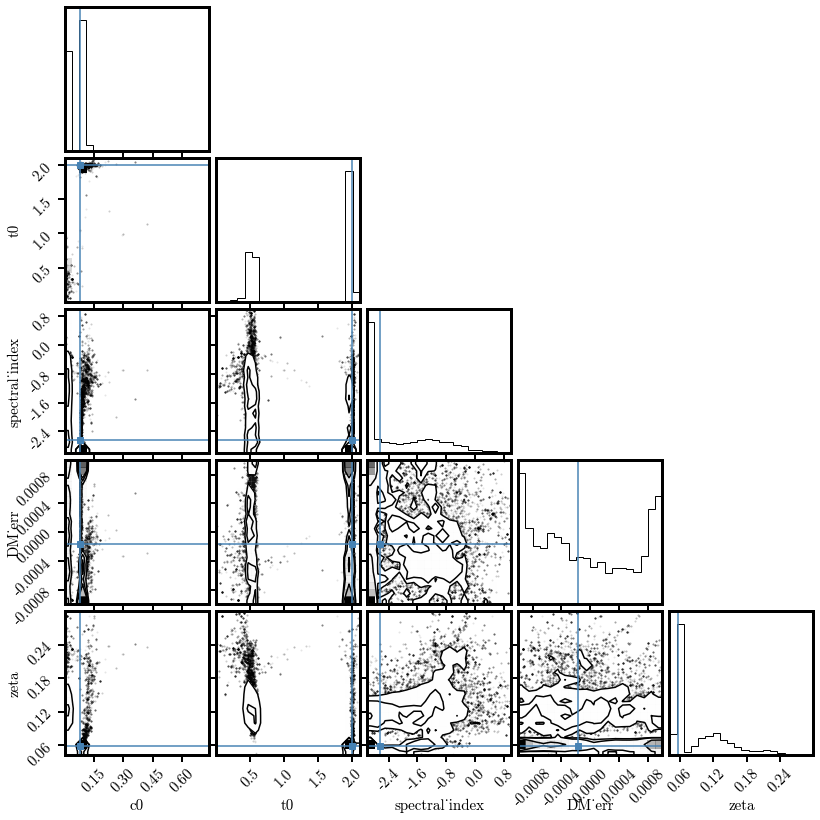

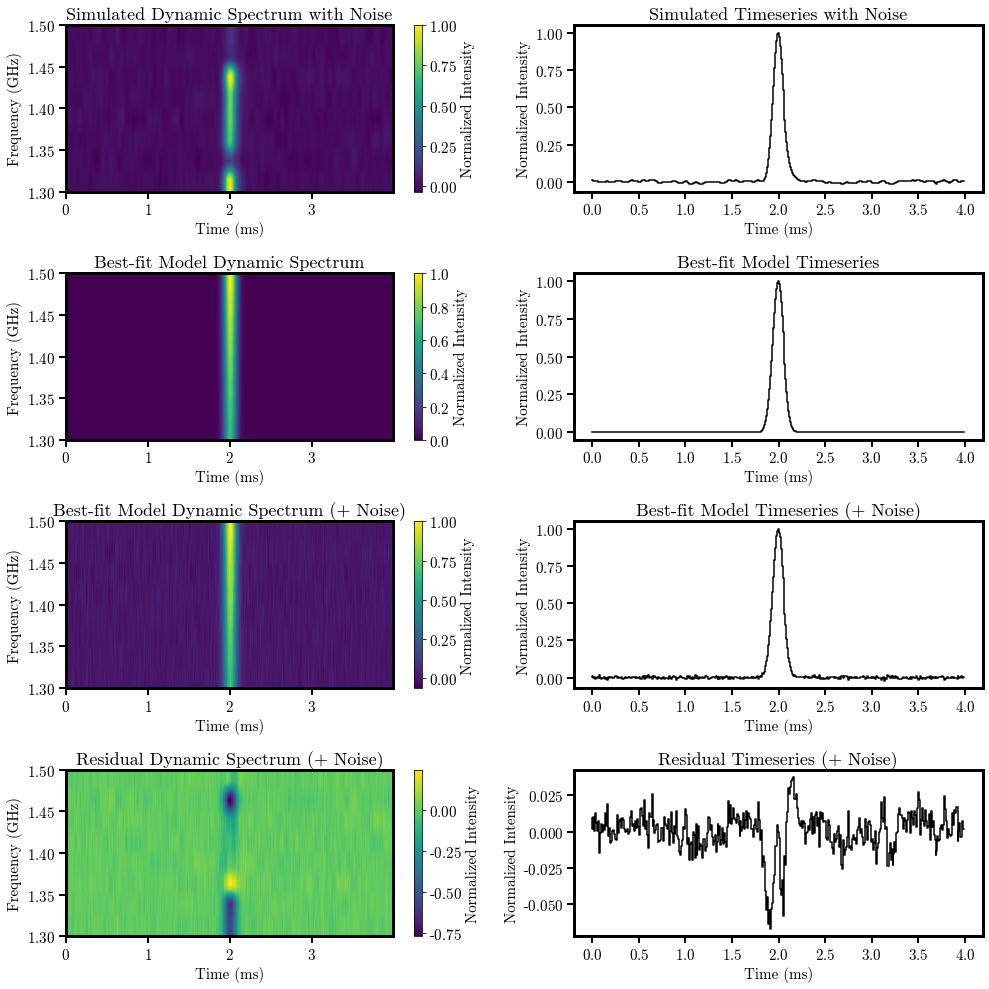

Mean acceptance fraction: 0.23402


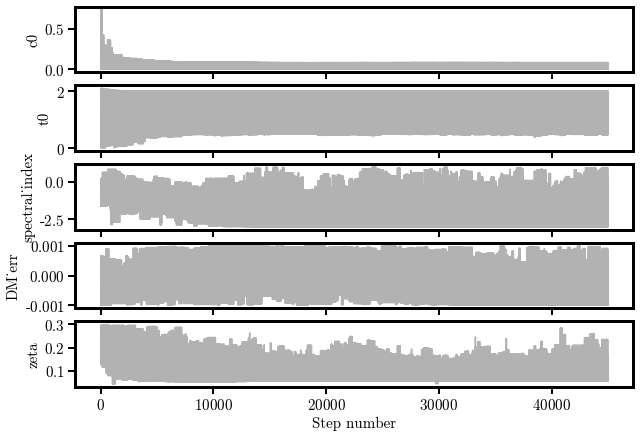

In [11]:
# Plot the data and the best-fit model
#best_fit_index = np.argmax(best_sampler.get_log_prob(discard=burn_in, flat=True))
#best_fit_index = np.argmax(log_prob)
#best_fit_params = samples[best_fit_index]

print(f'Best Fit Params: {best_fit_params}')

# Plot the corner plot
fig = corner.corner(relevant_samples, labels=labels, truths=best_fit_params)

for ax in fig.axes:
    # Spine widths
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)

    # Tick parameters
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='minor', axis='y', length=5)

plt.show()

# Compute the model spectrum using the best-fit parameters
best_fit_model = model_instance.model(best_fit_params, model_type=best_model)

# Normalized data
norm_data = model_instance.data / np.max(model_instance.data)
norm_data_timeseries = model_instance.data.sum(0) / np.max(model_instance.data.sum(0))

# Normalized model
norm_model = best_fit_model / np.max(best_fit_model)
norm_model_timeseries = best_fit_model.sum(0) / np.max(best_fit_model.sum(0))

# Plot the data and the best-fit model separately for comparison
plt.figure(figsize=(14, 14))

for i in range(1, 9):
    plt.subplot(4, 2, i)
    ax = plt.gca()
    
    # Spine widths
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)

    # Tick parameters
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='minor', axis='y', length=5)

# Plot the data
plt.subplot(4, 2, 1)
extent = [time[0], time[-1], freq[0], freq[-1]]
plt.imshow(norm_data, extent=extent, aspect='auto', origin='upper', cmap='viridis')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (GHz)')
plt.title('Simulated Dynamic Spectrum with Noise')

plt.subplot(4, 2, 2)
plt.step(time, norm_data_timeseries, c='k')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Intensity')
plt.title('Simulated Timeseries with Noise')

# Plot the best-fit model
plt.subplot(4, 2, 3)
plt.imshow(norm_model, extent=extent, aspect='auto', origin='lower', cmap='viridis')
#plt.imshow(norm_noisy_model, extent=extent, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (GHz)')
plt.title('Best-fit Model Dynamic Spectrum')

plt.subplot(4, 2, 4)
plt.step(time, norm_model_timeseries, c='k')
#plt.plot(time, norm_noisy_timeseries)
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Intensity')
plt.title('Best-fit Model Timeseries')

# Plot the best-fit model with added noise (based on the original data)
# Generate synthetic noise with the same shape as the model
noise = np.random.normal(loc=0.0, scale=model_instance.noise_std[:, np.newaxis], size=best_fit_model.shape)

# Add the synthetic noise to the fitted model
noisy_model = best_fit_model + noise
norm_noisy_model = noisy_model / np.max(noisy_model)

# Integrate to get the noisy timeseries
noisy_timeseries = np.nansum(norm_noisy_model, axis = 0)
norm_noisy_timeseries = noisy_timeseries / np.max(noisy_timeseries)

plt.subplot(4, 2, 5)
#plt.imshow(norm_model, extent=extent, aspect='auto', origin='lower', cmap='viridis')
plt.imshow(norm_noisy_model, extent=extent, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (GHz)')
plt.title('Best-fit Model Dynamic Spectrum (+ Noise)')

plt.subplot(4, 2, 6)
#plt.plot(time, norm_model_timeseries)
plt.step(time, norm_noisy_timeseries, c='k')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Intensity')
plt.title('Best-fit Model Timeseries (+ Noise)')

# Plot the residuals
plt.subplot(4, 2, 7)
plt.imshow(norm_data - norm_noisy_model, extent=extent, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (GHz)')
plt.title('Residual Dynamic Spectrum (+ Noise)')

plt.subplot(4, 2, 8)
plt.step(time, norm_data_timeseries - norm_noisy_timeseries, c='k')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Intensity')
plt.title('Residual Timeseries (+ Noise)')

plt.tight_layout()
plt.show()

# Check the mean acceptance fraction
print("Mean acceptance fraction:", np.mean(best_sampler.acceptance_fraction))

# Trace plots to assess convergence
ndim = len(labels)
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    axes[i].plot(samples[:, i], "k", alpha=0.3)
    axes[i].set_ylabel(labels[i])
    # Spine widths
    axes[i].spines['top'].set_linewidth(3)
    axes[i].spines['bottom'].set_linewidth(3)
    axes[i].spines['left'].set_linewidth(3)
    axes[i].spines['right'].set_linewidth(3)

    # Tick parameters
    axes[i].tick_params(which='both', width=2)
    axes[i].tick_params(which='major', length=7)
    axes[i].tick_params(which='minor', length=5)
    axes[i].tick_params(which='minor', axis='y', length=5)
axes[-1].set_xlabel("Step number")
plt.show()


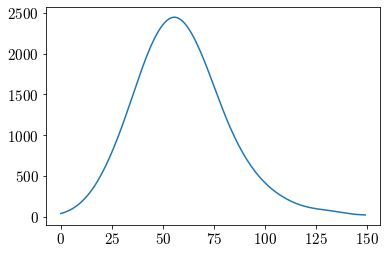

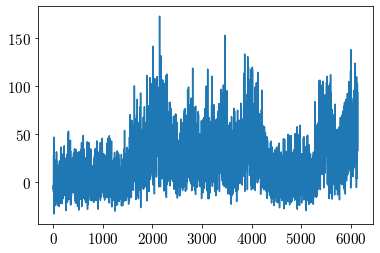

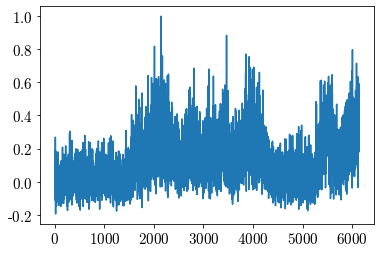

In [12]:
plt.plot(np.nansum(intensity[:, 725:875], axis = 0))
plt.show()
plt.plot(np.nansum(intensity[:, 725:875], axis = 1))
plt.show()
spectrum_lim = np.nansum(intensity[:, 725:875], axis=1)
spec_norm = spectrum_lim / np.max(spectrum_lim)
plt.plot(spec_norm)
plt.show()

In [17]:
def autocorr(x, v=None,zerolag=True,maxlag=None):
    """
    x is the 1D array you want to autocorrelate
    v is the array of 1s and 0s representing a mask where 1 is no mask, and 0 is mask
    zerolag = True will keep the zero lag noise spike, otherwise it won't compute the zero lag
    maxlag = None will compute the ACF for the entire length of x
    maxlag = bin_number will compute the ACF for lags up to x[bin_number]
    """
    nchan=len(x)
    if v is None:
        v = np.ones_like(x)
    x = x.copy()
    x[v!=0] -= x[v!=0].mean()
    if maxlag==None:
        ACF = np.zeros_like(x)
    else:
        ACF = np.zeros_like(x)[:int(maxlag)]
    #print(maxlag)
    #print('acf length', len(ACF))
    for i in tqdm(range(len(ACF))):
        if zerolag == False:
                if i>1:
                        m = shift(v,0,nchan)*shift(v,i,nchan)
                        ACF[i-1] = np.sum(shift(x,0,nchan)*shift(x, i,nchan)*m)/np.sqrt(np.sum(shift(x, 0, nchan)**2*m)*np.sum(shift(x, i, nchan)**2*m))
        else:
                m = shift(v,0,nchan)*shift(v,i,nchan)
                ACF[i] = np.sum(shift(x,0,nchan)*shift(x, i,nchan)*m)/np.sqrt(np.sum(shift(x, 0, nchan)**2*m)*np.sum(shift(x, i, nchan)**2*m))
            

    return ACF

100%|██████████| 6144/6144 [00:01<00:00, 4181.24it/s]


[[Model]]
    Model(lorentz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 141
    # data points      = 524
    # variables        = 3
    chi-square         = 0.03577289
    reduced chi-square = 6.8662e-05
    Akaike info crit   = -5020.23771
    Bayesian info crit = -5007.45324
    R-squared          = 0.98755984
[[Variables]]
    gamma1:  7515.04758 +/- 136.606211 (1.82%) (init = 1)
    m1:      0.65405541 +/- 0.00617585 (0.94%) (init = 1)
    c:      -0.01427554 +/- 0.00846467 (59.29%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9965
    C(gamma1, c)  = -0.9809
    C(gamma1, m1) = +0.9655


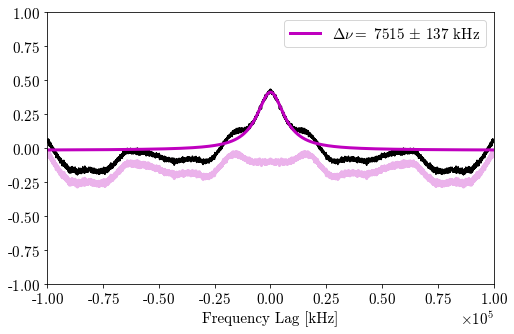

In [19]:
#spec_norm = spectrum / np.max(spectrum)
spectrum_lim = np.nansum(intensity[:, 725:875], axis=1)
spec_norm = spectrum_lim / np.max(spectrum_lim)
acf=autocorr(spec_norm, zerolag=True)
lags=np.arange(len(acf))+1
acf=acf[1:]
lags=lags[1:]
acf=np.concatenate((acf[::-1],acf))
lags=np.concatenate((-1*lags[::-1],lags))*30.51757812

f_res=30.51757812 #kHz
lag_range_for_fit=8000 #somewhat arbitrary, 2000 works well to successfully fit the central peak

gmodel = Model(lorentz)
acf_for_fit = acf[int(len(acf)/2.)-int(lag_range_for_fit/f_res):int(len(acf)/2.)+int(lag_range_for_fit/f_res)]
lags_for_fit = lags[int(len(acf)/2.)-int(lag_range_for_fit/f_res):int(len(acf)/2.)+int(lag_range_for_fit/f_res)]
#result = gmodel.fit(acf_for_fit, x=lags_for_fit, gamma1=10, m1=1,gamma2=100,m2=1, c=0)
result = gmodel.fit(acf_for_fit, x=lags_for_fit, gamma1=1, m1=1,c=0)
print(result.fit_report())

fig = plt.figure(figsize = (8, 5))

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-4, 4))

label_str = r'$\Delta \nu =$ ' + str(round(result.params['gamma1'].value)) + r' $\pm$ ' + str(round(result.params['gamma1'].stderr)) + ' kHz'

plt.step(lags, acf, c = 'k')
plt.plot(lags, lorentz(lags, result.params['gamma1'], result.params['m1'], result.params['c']), c = 'm', lw = 3, label = label_str)
plt.plot(lags, acf - lorentz(lags, result.params['gamma1'], result.params['m1'], result.params['c']) - 0.1, c = 'm', alpha = 0.3, lw = 3)

plt.xlim(-1e5, 1e5)
plt.ylim(-1, 1)
plt.xlabel('Frequency Lag [kHz]')
plt.legend()
plt.show()

In [20]:
import numpy as np
from numpy.fft import fft, ifft

def structure_function_1d(S):
    """
    Compute the 1D second-order structure function D(Δν)
    from a 1D array S(ν) using an FFT-based autocorrelation.
    
    Parameters:
    -----------
    S : 1D numpy array
        Intensity or amplitude as a function of frequency channel.
    
    Returns:
    --------
    D : 1D numpy array
        The structure function, D(Δν), for lags Δν = 0 .. N-1,
        assuming S is length N.
    """
    N = len(S)
    
    # Zero-pad to length 2N (to avoid wrap-around)
    padded_length = 2 * N
    S_padded = np.zeros(padded_length, dtype=np.float64)
    S_padded[:N] = S  # put data in the first half
    
    # Compute FFT
    S_fft = fft(S_padded)
    
    # Compute power spectrum: |S_fft|^2
    power_spectrum = S_fft * np.conj(S_fft)
    
    # Inverse FFT -> autocorrelation (unnormalized)
    R_padded = ifft(power_spectrum)
    
    # R_padded[k] corresponds to R(k) in "wrapped" sense,
    # but for k from 0..N-1, we get valid unwrapped autocorrelation lags
    R = np.real(R_padded[:N])  # only keep the first N
    
    # The zero-lag autocorrelation:
    R0 = R[0]
    
    # Structure function: D(Δν) = 2[R(0) - R(Δν)]
    D = 2.0 * (R0 - R)
    
    return D

def estimate_scint_bandwidth(D, method='half_power'):
    """
    Estimate a 'scintillation bandwidth' from the 1D structure function D(Δν).
    We'll define it using the autocorrelation half-power point (common in radio).
    
    Methods:
    --------
    'half_power': 
        - If D(∞) ~ 2 R(0), then the half-power point in correlation
          is R(0)/2, corresponding to D(Δν) = R(0). 
        - Numerically, we find the smallest Δν where D(Δν) >= R(0).
    'e_folding': 
        - Alternatively, one might define a scale where R(Δν) drops to 1/e.
        - That corresponds to D(Δν) = 2 R(0) (1 - 1/e).
        - You could implement that similarly.
    
    Returns:
    --------
    delta_nu_scint : float or int
        The approximate scintillation bandwidth (in channels).
        You can convert to physical frequency units if you know the channel spacing.
    """
    N = len(D)
    # Zero-lag value of structure function (which is D(0) = 2[R(0) - R(0)] = 0)
    # We also need R(0) to be half-power. R(0) can be found from D(∞) ~ 2 R(0) if R(∞) ~ 0.
    
    # The saturation value of D at large lag (assuming correlation goes to 0) is D_inf = 2 R(0).
    D_inf = np.mean(D[int(0.9*N):])  # approximate by mean of last 10% of points
    R0 = D_inf / 2.0  # => R(0)
    
    if method == 'half_power':
        # half-power in correlation => R(Δν) = R(0)/2
        # => D(Δν) = 2[R(0) - R(Δν)] = 2[R(0) - R(0)/2] = R(0).
        threshold = R0  # we look for D(Δν) = R(0)
    elif method == 'e_folding':
        # R(Δν) = R(0)/e => D(Δν) = 2[R(0) - R(0)/e] = 2 R(0) (1 - 1/e)
        threshold = 2.0 * R0 * (1.0 - 1.0/np.e)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Find first lag where D exceeds the threshold
    # (some smoothing or interpolation might be needed in real data)
    for lag in range(1, N):
        if D[lag] >= threshold:
            return lag
    
    # If it never crosses, return max
    return N - 1


Estimated scintillation bandwidth (MHz): 7415.771483160001


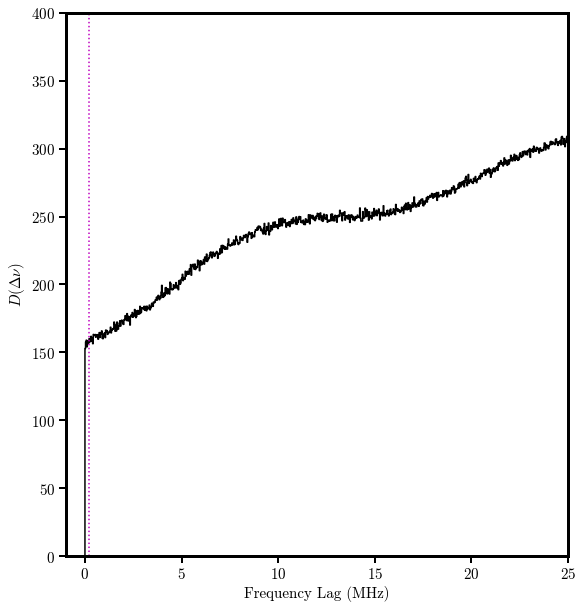

In [22]:
# Compute the structure function
D = structure_function_1d(spec_norm)
freq_lags = np.arange(len(D)) * fres
# Estimate scintillation bandwidth (in channel units)
# Use the half-power criterion for demonstration
delta_nu_scint = estimate_scint_bandwidth(D, method='half_power')
delta_nu_scint *= fres
print("Estimated scintillation bandwidth (MHz):", delta_nu_scint*1e3)

#delta_nu_scint = estimate_scint_bandwidth(D, method='e_folding')
#print("Estimated scintillation bandwidth (channels):", delta_nu_scint*30.51757812)

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (9, 10))

# Increase border thickness
current_axes = plt.gca()
axes.spines['top'].set_linewidth(3)
axes.spines['bottom'].set_linewidth(3)
axes.spines['left'].set_linewidth(3)
axes.spines['right'].set_linewidth(3)

axes.tick_params(which='both', width=2,)
axes.tick_params(which='major', length=7)
axes.tick_params(which='minor', length=5)
axes.tick_params(which='minor', axis = 'y', length=5)

axes.step(freq_lags, D, c = 'k')
axes.axvline(delta_nu_scint*fres, c = 'm', linestyle = 'dotted')
axes.set_ylabel(r'$D(\Delta \nu)$')
axes.set_xlabel(r'Frequency Lag (MHz)')
axes.set_xlim(-1, 25)
axes.set_ylim(0, 400)
#axes.set_yscale('log')
plt.show()

# If you know your channel spacing Δν_chan, you can multiply by that to get physical units
# e.g., freq_bw = delta_nu_scint * delta_nu_chan